In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [83]:
lis = [1,2,3,4,5,6,7]
x = lambda a: a**2
[x(l) for l in lis] 

[1, 4, 9, 16, 25, 36, 49]

## Week 2: DNN

## Data Preparation
- features: some values (window_size) in the series (not time values on x-axis)
- labels: the next value

In [51]:
dataset = tf.data.Dataset.range(10)

# drop_remainder: windows of 5 only
dataset = dataset.window(size = 5, shift = 1, drop_remainder= True)
for window in dataset:
    for val in window:
        print(val.numpy(), end = " ")
    print("")

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


2022-09-23 17:30:34.729927: W tensorflow/core/framework/dataset.cc:768] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [52]:
# convert to numpy
dataset_flat_mapped = dataset.flat_map(lambda window: window.batch(5))
for window in dataset_flat_mapped:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [79]:
# split into X and Y
dataset_splitted = dataset_flat_mapped.map(lambda window: (window[:-1], window[-1]))
# Shuffle
dataset_shuffled = dataset_splitted.shuffle(buffer_size = 10)
# batch the data, prefetch improves throughput
dataset_batched = dataset_shuffled.batch(2).prefetch(1)
for x, y in dataset_batched:
    print(x.numpy(), y.numpy())

[[2 3 4 5]
 [1 2 3 4]] [6 5]
[[3 4 5 6]
 [4 5 6 7]] [7 8]
[[5 6 7 8]
 [0 1 2 3]] [9 4]


In [86]:
# Combine
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
    dataset_flat_mapped = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset_shuffled_splitted = dataset_flat_mapped.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset_batched = dataset_shuffled_splitted.batch(batch_size).prefetch(1)

    return dataset_batched

## Feeding into NN

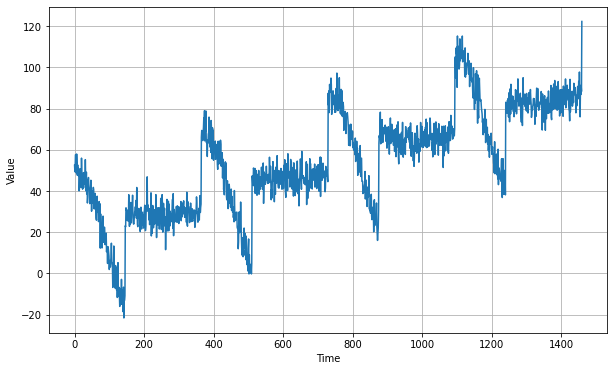

In [112]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

    # Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [113]:
# train_test_split
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [137]:
window_size = 20
batch_size = 32
shuffle_buffer = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer)

# # single linear regression model
# model = tf.keras.models.Sequential([
# tf.keras.layers.Dense(1, input_shape = [window_size], name = "l0")
# ])

# DNN
model = tf.keras.models.Sequential([
tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"),
tf.keras.layers.Dense(10, activation = "relu"),
# Since linear_reg always: last layer is single unit & linear activation
tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))


model.compile(
    loss = "mse",
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9),
)
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
46/46 [==============================] - 1s 7ms/step - loss: 808.5578 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 172.4918 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 1s 7ms/step - loss: 124.9004 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 121.9617 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 120.7177 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 119.4701 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 118.0120 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 0s 8ms/step - loss: 116.4113 - lr: 2.2387e-08
Epoch 9/100
46/46 [==============================] - 0s 5ms/step - loss: 114.6940 - lr: 2.5119e-08
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: 112.6983 - lr: 2.8184e-08
Epoch 11/

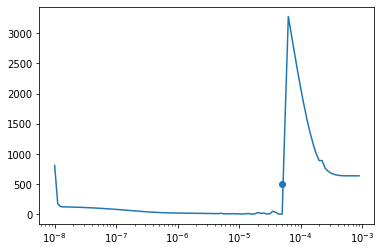

In [140]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.scatter(5e-5, 500)

from the plot, the best learning rate is 5e-5

In [107]:
# prediction
print(model.predict(series[None, 1:21]))

linear_reg_forecast = []
for time in range(len(series) - window_size):
    linear_reg_forecast.append(model.predict(series[None, time:time + window_size]))

linear_reg_forecast = np.array(linear_reg_forecast)
linear_reg_forecast = linear_reg_forecast[split_time - window_size:][:,0,0]

1/1 [==============================] - 0s 23ms/step
[[52.623478]]
1/1 [==============================] - 0s 26ms/step


(1441, 1, 1)

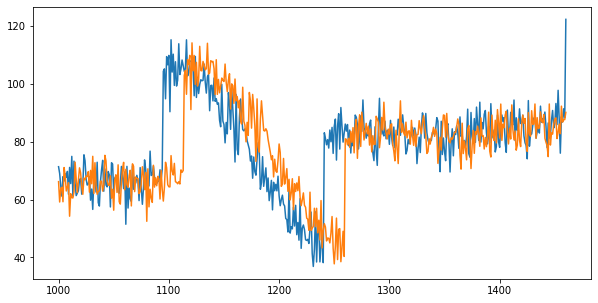

In [124]:
plt.figure(figsize=(10,5))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, linear_reg_forecast)

In [125]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, linear_reg_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, linear_reg_forecast).numpy())

188.70438
9.291371


# Week 3: RNNs
input_shape = [batch size, # time steps, # dims (1 for univariate: ourcase)]

output_shape = [batch size, # units, # time stamps]

state_output(H)_shape = output_shape

## seq_to_seq vs seq_to_vec

In [ ]:
model = tf.keras.models.Sequential([
    # input_shape [batch_size: None (can handle any size), # time_stamps: None (can handle any size), # dims]
    tf.keras.layers.SimpleRNN(20, reutn_sequences = True, input_shape = [None, 1]),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1)
])

## Lambda layers
apply arbitrary operations

In [ ]:
# clearing internal variables, models doesn't affect each other
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    # expand dims
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.SimpleRNN(20, reutn_sequences = True),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1),
    # scaling
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.8)

# Huber is less sensitive to noise
model.compile(loss = tf.keras.Huber(),
optimizer = optimizer,
metrics = ["mae"])

## LSTMs (Bidirectional)
better than RNNS, no vanishing gradients and long term dependencies

# Week 4: LSTMSs + Conv1D

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "casual", activation = "relu", input_shape = [None, 1]),
    tf.keras.layers.LSTM(20, reutn_sequences = True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(20, "relu"),
    tf.keras.layers.Dense(1),
    # scaling
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

bidirectional LSTMs often cause overfitting due to noise (errors) due to small batch sizes